In [3]:
# %matplotlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFilter
import numpy as np
import synthtiger.utils.image_util as image_util
import os
import shutil


In [22]:
# Read the original image
img = cv2.imread('test.jpg') 
img = cv2.resize(img, (640,640))

# Display original image
# cv2.imshow('Original', img)
# cv2.waitKey(0)
 
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
 
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
# cv2.imshow('Sobel X', sobelx)
# cv2.waitKey(0)
# cv2.imshow('Sobel Y', sobely)
# cv2.waitKey(0)
# cv2.imshow('Sobel X Y using Sobel() function', sobelxy)
# cv2.waitKey(0)
 
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
# cv2.imshow('Canny Edge Detection', edges)
# cv2.waitKey(0)
 
cv2.destroyAllWindows()

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

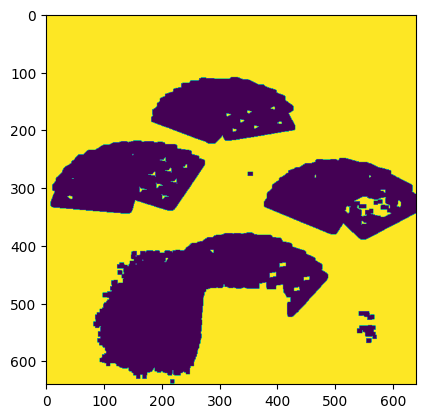

In [46]:
ret, thresh = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# plt.imshow(thresh)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
fg = cv2.erode(opening, kernel, iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(fg)
fg

In [10]:
thresh = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)[1]
# get the (largest) contour
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# draw white filled contour on black background
result = np.zeros_like(edges)
cv2.drawContours(result, contours, 0, (255,255,255), cv2.FILLED)

# save results
cv2.imwrite('knife_edge_result.jpg', result)

True

In [18]:
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

len(contours[0])

242

In [73]:
grad = np.sqrt(sobelx**2 +sobely**2)
grad2 = (grad*255/grad.max()).astype(np.uint8)
# plt.imshow(grad2)
grad3 = np.array(grad2)
grad3[grad3<60] = 0

In [2]:
img = cv2.imread('../../results/images/0/1.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('../../results/masks/0/1.png') 
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
# mask= np.ones_like(mask) * 255

# resulting image 
# plt.imshow(img) 

In [7]:
f=open('../../results/coords.txt', 'r')
x = f.readline()
x = f.readline()
# x = f.readline()
f.close()

In [8]:
f=open('../../results/gt.txt', 'r')
y = f.readline()
y = f.readline()
# x = f.readline()
f.close()

In [9]:
y = y[:-1].split('\t')[1:]

In [10]:
bboxes_str = x[:-1].split('\t')[1:]
bboxes = []
for bbox_str in bboxes_str:
    x1, y1, x2, y2 = bbox_str.split(',')
    bboxes.append([int(x1), int(y1), int(x2) - int(x1), int(y2) - int(y1)])
# bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes]

7


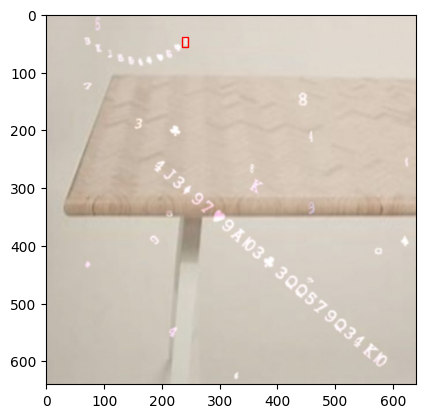

In [42]:
fig, ax = plt.subplots()
# Display the image
ax.imshow(img)

# Create a Rectangle patch
i=0
for label, bbox in zip(y, bboxes):
    i+=1
    if i==12:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        print(label)

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()
        break



In [19]:
plt.show()

In [495]:
def paste_image(src, dst, quad, mode="normal"):
    src_height, src_width = src.shape[:2]
    dst_height, dst_width = dst.shape[:2]
    origin = np.array(
        [[0, 0], [src_width, 0], [src_width, src_height], [0, src_height]],
        dtype=int,
    )
    quad = np.array(quad, dtype=int)

    src_topleft = np.amin(quad, axis=0)
    src_bottomright = np.amax(quad, axis=0)
    src_size = tuple(src_bottomright - src_topleft)
    dst_topleft = [0, 0]
    dst_bottomright = [dst_width, dst_height]
    dst_size = (dst_width, dst_height)

    topleft = np.amax([src_topleft, dst_topleft], axis=0)
    bottomright = np.amin([src_bottomright, dst_bottomright], axis=0)
    print(topleft, bottomright)
    if any(topleft >= bottomright):
        return None

    if not all(
        (
            quad[0][0] == quad[3][0],
            quad[1][0] == quad[2][0],
            quad[0][1] == quad[1][1],
            quad[2][1] == quad[3][1],
            quad[1][0] - quad[0][0] == quad[2][0] - quad[3][0] == src_width,
            quad[3][1] - quad[0][1] == quad[2][1] - quad[1][1] == src_height,
        )
    ):
        print('quad', quad)
        origin = origin.astype(np.float32)
        quad = (quad - src_topleft).astype(np.float32)
        matrix = cv2.getPerspectiveTransform(origin, quad)
        src = cv2.warpPerspective(src, matrix, src_size)

    sx, sy = np.clip(topleft - src_topleft, (0, 0), src_size)
    dx, dy = np.clip(bottomright - src_topleft, (0, 0), src_size)
    src_area = (slice(sy, dy), slice(sx, dx))
    print(sx, sy, dx, dy)

    sx, sy = np.clip(topleft - dst_topleft, (0, 0), dst_size)
    dx, dy = np.clip(bottomright - dst_topleft, (0, 0), dst_size)
    dst_area = (slice(sy, dy), slice(sx, dx))
    print(sx, sy, dx, dy)
    print(src[src_area].shape, dst[dst_area].shape)

    dst[dst_area] = image_util.blend_image(src[src_area], dst[dst_area], mode=mode)

In [496]:
img.shape

(34, 34, 3)

In [497]:
img1 = image_util.create_image((100,100)).astype(np.uint8)
# img2 = np.concatenate([img, mask], axis=-1)

In [498]:
def paste_text( text_img, mask, bbox, bg_layer):
        height,width = text_img.shape[:2]
        print(height,width)
        img1 = image_util.create_image((100,100)).astype(np.uint8)
        if mask is not None:
                if len(mask.shape) == 2:
                        mask = np.expand_dims(mask, -1)
                if text_img.shape[-1] > 3:
                        raise NotImplementedError
                img2 = np.concatenate([text_img, mask], axis=-1)
        quad = image_util.to_quad(bbox)
        start_x_sample = np.random.randint(0, 100 - width)
        start_y_sample = np.random.randint(0, 100 - height)
        print(start_x_sample,start_y_sample)
        bbox_new = [
                bbox[0] + start_x_sample,
                bbox[1] + start_y_sample,
                bbox[2],
                bbox[3],
        ]
        quad = image_util.to_quad(bbox_new)
        paste_image(img2, img1, quad)
        return img1

In [499]:
bbox

[3, 5, 25, 31]

34 34
57 9
[60 14] [85 45]
quad [[60 14]
 [85 14]
 [85 45]
 [60 45]]
0 0 25 31
60 14 85 45
(31, 25, 4) (31, 25, 4)


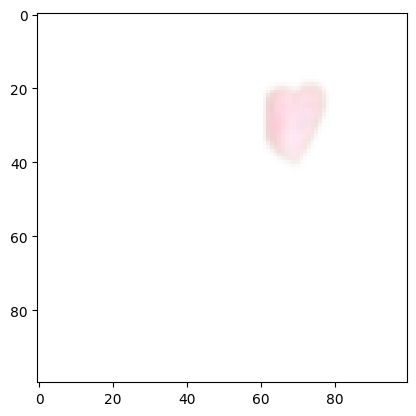

In [503]:
# bbox = np.array([0,0,47,60])
img1 = paste_text( img, mask, bbox, None)
plt.imshow(img1)


In [547]:
bbox1 = np.array([[1,2,3,4], [11,11,4,5]])
bbox2 = np.array([1,2,3,4])

bbox2 = np.repeat(np.expand_dims(bbox2,0), bbox1.shape[0], 0)

concatbox = np.concatenate([np.expand_dims(bbox1, -1), np.expand_dims(bbox2, -1)], axis=-1)
x_left = np.max(concatbox[:, 0],-1)
y_top = np.max(concatbox[:, 1], -1)
x_right = np.min(concatbox[:, 0]+concatbox[:,2], -1)
y_bottom = np.min(concatbox[:, 1]+concatbox[:,3], -1)
# x_left = np.max(bbox1[0], bbox2[0])
#     y_top = max(bbox1[1], bbox2[1])
#     x_right = min(bbox1[0]+bbox1[2], bbox2[0]+bbox2[2])
#     y_bottom = min(bbox1[1]+bbox1[3], bbox2[1]+bbox2[3])

In [557]:
np.any(np.all(np.vstack([x_right > x_left, y_bottom > y_top]), axis=0))

True

In [1]:
gt2label = {
    '1': 9,
    '2': 1,
    '3': 2,
    '4': 3,
    '5': 4,
    '6': 5,
    '7': 6,
    '8': 7,
    '9': 8,
    '0': 0,
    'q': 16,
    'w': 13,
    'e': 14,
    'r': 15,
    'a': 10,
    's': 12,
    'd': 11,
}

In [4]:
image_dim = [640, 640]
gt_dict = {}
bbox_dict = {}
image_dict = {}
image_key_set = {}
with open('../../results/2/gt.txt', 'r') as f:
    with open('../../results/2/coords.txt', 'r') as g:
        for line in f:
            assert '\n' in line
            split = line[:-1].split('\t')
            image_key = split[0].split('/')[-1].split('.')[0]
            labels = [gt2label[x] for x in split[1:]]
            gt_dict[image_key] = labels
            image_dict[image_key] = split[0]

        for line in g:
            split2 = line[:-1].split('\t')
            image_key2 = split2[0].split('/')[-1].split('.')[0]
            bboxes = [list(map(int, x.split(','))) for x in split2[1:]]
            bboxes = np.array(bboxes)
            center_x = (bboxes[:,2] + bboxes[:,0])/image_dim[1]/2
            center_y = (bboxes[:,3] + bboxes[:,1])/image_dim[0]/2
            width = (bboxes[:,2] - bboxes[:,0])/image_dim[1]
            height = (bboxes[:,3] - bboxes[:,1])/image_dim[0]
            bboxes_new = np.vstack([center_x, center_y, width, height]).T
            assert np.all(bboxes_new <= 1) and  np.all(bboxes_new >= 0)
            bbox_dict[image_key2] = bboxes_new
bboxes_new.shape

(30, 4)

In [5]:
gt_dict.keys()

dict_keys(['2', '0', '3', '1', '4', '6', '5', '8', '9', '11', '7', '10', '13', '14', '15', '16', '17', '19', '12', '20', '18', '23', '21', '25', '27', '22', '26', '28', '30', '29', '24', '32', '31', '33', '36', '35', '37', '39', '34', '38', '42', '40', '43', '41', '45', '44', '49', '46', '48', '50', '51', '52', '53', '47', '56', '54', '55', '58', '57', '61', '60', '64', '65', '62', '59', '67', '63', '68', '69', '71', '66', '72', '70', '75', '73', '76', '74', '80', '81', '78', '82', '77', '79', '85', '86', '87', '84', '83', '89', '88', '91', '92', '95', '96', '93', '97', '90', '99', '94', '98', '101', '104', '100', '102', '103', '105', '107', '109', '110', '106', '111', '112', '108', '114', '115', '113', '117', '116', '118', '122', '119', '121', '123', '124', '120', '126', '125', '129', '128', '127', '131', '133', '134', '130', '135', '136', '139', '137', '138', '141', '132', '140', '144', '142', '145', '143', '146', '149', '150', '148', '152', '151', '153', '154', '155', '147', '156', 

In [6]:
image_keys = set(gt_dict.keys()).union(set(bbox_dict.keys()))
assert len(gt_dict.keys()) == len(image_keys)
assert len(bbox_dict.keys()) == len(image_keys)

In [7]:
keys = gt_dict.keys()
num_samples = len(keys)
num_train = int(.6 * num_samples)
num_val = int(.2 * num_samples)
train_keys = list(gt_dict.keys())[:num_train]
val_keys = list(gt_dict.keys())[num_train: num_train+num_val]
test_keys = list(gt_dict.keys())[num_train+num_val:]


In [11]:
def save_files(key, img_dir, label_dir):
    shutil.copy2('../../results/'+image_dict[key], img_dir)
    label_filename = os.path.join(label_dir, key+'.txt')
    with open(label_filename, 'w') as f:
        gts = gt_dict[key]
        bboxes = bbox_dict[key]
        for gt, bbox in zip(gts, bboxes):
            line = ' '.join(map(str,[gt] + list(bbox))) + '\n'
            f.write(line)

In [13]:
train_image_dir = 'synthdata/train/images'
train_label_dir = 'synthdata/train/labels'
val_image_dir = 'synthdata/val/images'
val_label_dir = 'synthdata/val/labels'
test_image_dir = 'synthdata/test/images'
test_label_dir = 'synthdata/test/labels'
data_dir = 'synthdata'
dirs = [train_image_dir, train_label_dir, val_image_dir, val_label_dir, test_image_dir, test_label_dir, data_dir]

for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

for key in train_keys:
    save_files(key, train_image_dir+'/h'+str(key)+'.jpg', train_label_dir)
for key in val_keys:
    save_files(key, val_image_dir+'/h'+str(key)+'.jpg', val_label_dir)
for key in test_keys:
    save_files(key, test_image_dir+'/h'+str(key)+'.jpg', test_label_dir)